## **Rotary Positional Embeddings (RoPE)**

*Rotary Position Embedding (RoPE) is a technique used in transformer-based models to incorporate positional information into token representations. Unlike traditional positional encodings that rely on sine and cosine functions, RoPE utilizes rotation matrices to encode both absolute and relative positional information. This method was proposed as a way to enhance the effectiveness of positional embeddings in transformers.*

## **The Math**

*Rotary encoding transforms pairs of features by rotating in the 2D plane. That is, it organizes the d features as d/2
pairs. Each pair can be considered a coordinate in a 2D plane, and the encoding will rotate it by an angle depending on the position of the token.*

$$\text{Let } x_m^{(1)} \text{ and } x_m^{(2)} \text {be two features of the key or}\\
 \text{query of any head at position m.}\\
 \text{For simplicity assume x has only two features. Then the transformation is:}$$


$$\text{RoPE}(x_m^{(1)}, x_m^{(2)}, m) =
\begin{bmatrix}
\cos(m\theta) & -\sin(m\theta) \\
\sin(m\theta) & \cos(m\theta)
\end{bmatrix}
\begin{bmatrix}
x_m^{(1)} \\
x_m^{(2)}
\end{bmatrix}
= \begin{bmatrix}
x_m^{(1)}\cos(m\theta) - x_m^{(2)}\sin(m\theta) \\
x_m^{(2)}\cos(m\theta) + x_m^{(1)}\sin(m\theta)
\end{bmatrix}$$


$$ \Theta = \theta_i = 10,000^{-\frac{2(i-1)}{d}} , where ( i \in [1, 2, ..., 2d] ) \text{ for the ( 2d ) pairs of features.}$$

## **The Intuition**

We would like to find a positional encoding function ***f(x,l)*** for ***x*** and its position ***l*** such that, for two items ***q*** and ***k*** and at positions ***m*** and ***n***, the innner product between ***f(q,m)*** and ***f(k,n)*** is sensitive only to the values ***q*** and ***k*** and their relative position ***m - n***.

 A key piece of information is the geometric definition of the dot product between Euclidean vectors:

 $$q \cdot k = |q| |k| \cos \theta$$

 The RoPE embedding achieves this:

 \begin{align}
\mathrm{RoPE}(x, m) &= xe^{mi\theta} \\
\langle \mathrm{RoPE}(q_j, m), \mathrm{RoPE}(k_j, n)\rangle &= \langle q_j e^{mi\theta}, k_j e^{ni\theta} \rangle \\
&= q_j k_j e^{mi\theta} \overline{e^{ni\theta}} \\
&= q_j k_j e^{(m - n)i\theta} \\
&= \mathrm{RoPE}(q_j k_j, m - n)
\end{align}



In [18]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class RotaryPositionalEmbeddings(nn.Module):

  def __init__(self, d: int, base: int = 10_000):

    super().__init__()
    self.base = base
    self.d = d
    self.cos_cached = None
    self.sin_cached = None

  def _build_cache(self, x: torch.Tensor):

    if self.cos_cached is not None and x.shape[0] <= self.cos_cached.shape[0]:
      return

    seq_len = x.shape[0]

    theta = 1. / (self.base ** (torch.arange(0, self.d, 2).float() / self.d)).to(x.device) # THETA = 10,000^(-2*i/d) or 1/10,000^(2i/d)

    seq_idx = torch.arange(seq_len, device=x.device).float().to(x.device) #Position Index -> [0,1,2...seq-1]

    idx_theta = torch.einsum('n,d->nd', seq_idx, theta)  #Calculates m*(THETA) = [ [0, 0...], [THETA_1, THETA_2...THETA_d/2], ... [seq-1*(THETA_1), seq-1*(THETA_2)...] ]

    idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1) # [THETA_1, THETA_2...THETA_d/2] -> [THETA_1, THETA_2...THETA_d]


    self.cos_cached = idx_theta2.cos()[:, None, None, :] #Cache [cosTHETA_1, cosTHETA_2...cosTHETA_d]
    self.sin_cached = idx_theta2.sin()[:, None, None, :] #cache [sinTHETA_1, sinTHETA_2...sinTHETA_d]

  def _neg_half(self, x: torch.Tensor):

    d_2 = self.d // 2 #

    return torch.cat([-x[:, :, :, d_2:], x[:, :, :, :d_2]], dim=-1) # [x_1, x_2,...x_d] -> [-x_d/2, ... -x_d, x_1, ... x_d/2]


  def forward(self, x: torch.Tensor):

    self._build_cache(x)

    neg_half_x = self._neg_half(x)

    x_rope = (x * self.cos_cached[:x.shape[0]]) + (neg_half_x * self.sin_cached[:x.shape[0]]) # [x_1*cosTHETA_1 - x_d/2*sinTHETA_d/2, ....]

    return x_rope

*We pair up the positive cosines and negative half sines to get the final embeddings as follows*:

$$
\begin{bmatrix}
x_m^{(i)} \\
x_m^{(i+d/2)}
\end{bmatrix}
= \begin{bmatrix}
x_m^{(i)}\cos(m\theta_i) - x_m^{(i+d/2)}\sin(m\theta_i) \\
x_m^{(i+d/2)}\cos(m\theta_i) + x_m^{(i)}\sin(m\theta_i)
\end{bmatrix}$$

#Test

In [3]:
x = torch.tensor([[1, 2, 3, 4], [4, 5, 6, 7], [7, 8, 9, 10]], dtype=torch.float)
x = x[:, None, None, :]

In [4]:
RotaryPositionalEmbeddings(4)(x)





tensor([[[[  1.0000,   2.0000,   3.0000,   4.0000]]],


        [[[ -2.8876,   4.9298,   6.6077,   7.0496]]],


        [[[-11.0967,   7.7984,   2.6198,  10.1580]]]])

In [26]:
depth = 100
num_positions = 50
xs = torch.ones(num_positions, depth)
xs = xs[:, None, None, :]

pos_encoding = RotaryPositionalEmbeddings(100)(xs)
pos_encoding = pos_encoding.reshape([50, 100])



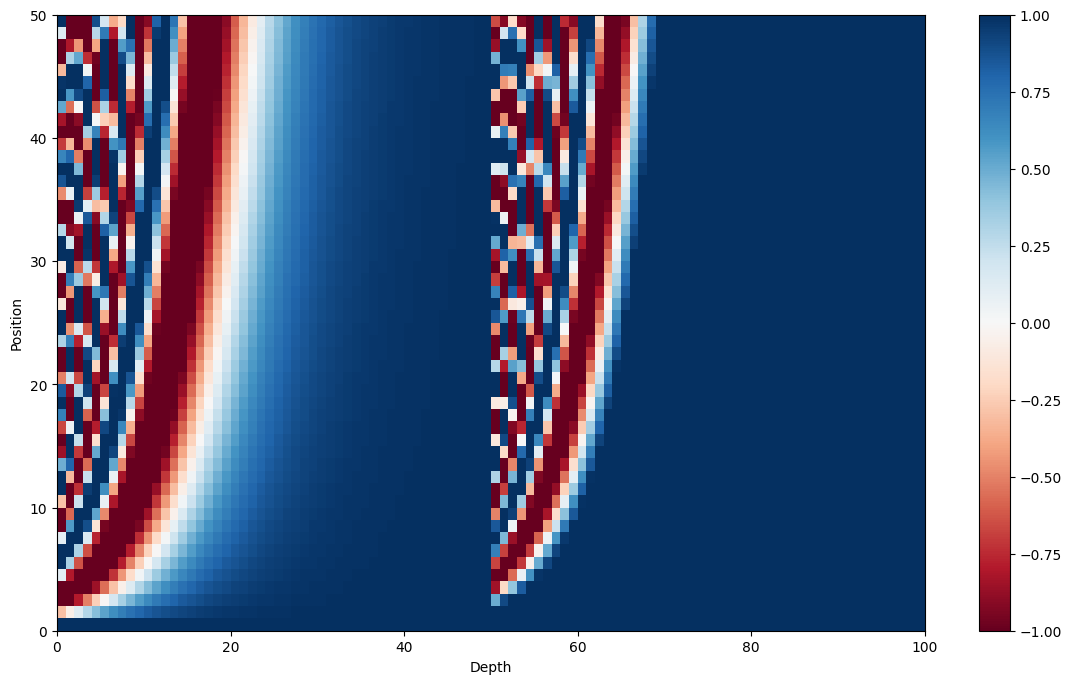

In [27]:
plt.figure(figsize=(14,8))
plt.pcolormesh(pos_encoding,
               # Use a diverging colormap so it's clear where zero is.
               cmap='RdBu', vmin=-1, vmax=1)
plt.xlim([0,depth])
plt.ylabel('Position')
plt.xlabel('Depth')
plt.colorbar()